# How To Make Spectrograms from EEG
In this notebook, we learn how to make spectrograms from EEG. The EEGs are waveforms and the Spectrograms are images. There is a discussion about this notebook [here][1].

In version 1-3, we also train a simple model using our EEG spectrograms to confirm that they work well. We observe that a model trained with EEG spectrograms performs better than baseline models using only train means.

# Exciting UPDATE!
Version 4 of this notebook uses a different formula to make spectrograms than earlier versions. I trained an EfficientNet model using the old version eeg spectrograms, new version spectrograms, and Kaggle spectrograms. We can see that the new version eeg spectrograms are **powerful**!

| Spectrogram | 5-Fold CV | LB |
| --- | --- | --- |
| Kaggle spectrogram | 0.73 | 0.57 |
| Old EEG formula | 0.84 on fold 1 | ?? |
| New EEG formula | 0.70 on fold 1| ?? |
| Use both Kaggle and New | 0.64 | 0.44 |

From the results above, we conclude that our new formula is probably similar or better than the true formula used to create the Kaggle spectrograms. Details about the old and new formula are in the next notebook section. 

# How To Use EEG Spectrograms
Examples of how to use new EEG spectrograms to boost CV score and LB score will be (or already are) published in recent versions of my EfficientNet starter notebook [here][2] and CatBoost starter notebook [here][3]

# Kaggle Dataset
The new EEG spectrograms from version 4 of this notebook have been uploaded to a Kaggle dataset [here][4]. We can attach this Kaggle dataset to our future notebooks to boost our CV scores and LB scores! Thank you everyone for upvoting my new EEG spectrogram Kaggle dataset!

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467877
[2]: https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57
[3]: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-67
[4]: https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms

In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, gc

train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print('Train shape', train.shape )
display( train.head() )

Train shape (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# The Bipolar Double Banana Montage
In the Kaggle discussion [here][1], we learn what information we need to make spectrograms from eegs. The following website [here][2] is helpful also. To build 1 spectrogram, we need 1 time series signal. Kaggle provides us with 19 eeg time signals, so we must combine them into 4 time signals to make 4 spectrograms.

In the diagram below, we see which electrode signals are needed to make the `LL, LP, RP, RR` spectrograms. Furthermore Kaggle discussions imply that most likely we create differences between consecutive electrodes and average the differences. For example, we create `LL spectrogram` with the formula: 

    LL = ( (Fp1 - F7) + (F7 - T3) + (T3 - T5) + (T5 - O1) )/4.
    
I am not positive that this is the correct formula. I also tried the formula below but it produced a worse CV score than the above formula, so perhaps the above is correct. I am confident that we only use these 5 electrodes to create `LL spectrogram`. I'm just a little unsure about the formula:

    LL = ( Fp1 + F7 + T3 + T5 + O1 )/5.
    
# Exciting UPDATE!
I believe the above two formulas are wrong. Many Kagglers have pointed out that the above formula reduces to `LL = ( Fp1 - O1 )/4` which means that it does not use all the EEG signals. The new formula below utilizes all the EEG signals and produces EEG spectrograms that achieve better CV score and LB score than the Kaggle spectrograms. Therefore I think the following formula is the correct one:

    LL Spec = ( spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1) )/4.
    
Since creating a spectrogram is a non-linear operation, the above formula which computes 4 spectrograms and then takes the average is different than the formula below which computes 1 spectrogam. And the above formula does utilize all EEG signals and cannot be reduced to a shorter formula (like the one below).

    LL Spec = spec( ( (Fp1 - F7) + (F7 - T3) + (T3 - T5) + (T5 - O1) )/4. )

![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/montage.png)

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467877
[2]: https://www.learningeeg.com/montages-and-technical-components

In [2]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

directory_path = 'EEG_Spectrograms/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Optional Signal Denoising with Wavelet transform
We can optionally denoise the signal before creating the spectrogram. I'm not sure yet if this creates better or worse spectrograms. We can experiment with this. This code comes from Yusaku5738 notebook [here][1] and was suggested by SeshuRajuP in the comments. We have many parent functions to use for denoising. Yusaku5738 suggests using `wavelet = db8`.

[1]: https://www.kaggle.com/code/yusaku5739/eeg-signal-denosing-using-wavelet-transform

In [3]:
import pywt
print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = None #'db8' #or "db8" or anything below

The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [4]:
# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

# Create Spectrograms with Librosa
We can use library librosa to create spectrograms. We will save them to disk. For each `eeg_id` we will make 1 spectrogram from the middle 50 seconds. We don't want to use more information than 50 seconds at a time because during test inference, we only have access to 50 seconds of EEG for each test `eeg_id`. We will create spectrograms of `size = 128x256 (freq x time)`.

The main function is 

    mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
              n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)
              
Let's explain these variables.
* `y` is the input time series signal
* `sr` is the sampling frequency. In this competition EEG is sample 200 times per sec
* `hop_length` produces image with `width = len(x)/hop_length`
* `n_fft` controls vertical resolution and quality of spectrogram
* `n_mels` produces image with `height = n_mels`
* `fmin` is smallest frequency in our spectrogram
* `fmax` is largest frequency in our spectrogram
* `win_length` controls hortizonal resolution and quality of spectrogram

In [5]:
import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    # Parameters for STFT
    sr = 200  # Sample rate
    n_fft = 1024  # Number of FFT points
    max_bin = int(20 * n_fft / sr)  # Limit for frequency bins (20 Hz)

    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

#             # RAW SPECTROGRAM
#             mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
#                   n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)
#             print("mel shape: ", mel_spec.shape)
#             # LOG TRANSFORM
#             width = (mel_spec.shape[1]//32)*32
#             print("mel width: ", width)
#             mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

#             # STANDARDIZE TO -1 TO 1
#             mel_spec_db = (mel_spec_db+40)/40 
#             img[:,:,k] += mel_spec_db
            
            # STFT SPECTROGRAM (From the raw EEG data, limiting frequency to 0-20Hz)
            D = librosa.stft(y=x, n_fft=n_fft, hop_length=len(x)//256, win_length=128)
#             print("D shape: ", D.shape)
            width = (D.shape[1]//32)*32
#             print("stft shape: ", width)
            spectrogram = np.abs(D)[:max_bin + 1, :]
            spectrogram_db = librosa.power_to_db(spectrogram)
#             print("shape: ", spectrogram_db.shape)
            
            freqs = np.linspace(0, 20, spectrogram_db.shape[0])
            target_freqs = np.linspace(0, 20, 128)
            
            rescaled_spectrogram = np.zeros((128, spectrogram_db.shape[1]))
            for i in range(spectrogram_db.shape[1]):
                rescaled_spectrogram[:, i] = np.interp(target_freqs, freqs, spectrogram_db[:, i])
            if (rescaled_spectrogram.shape != (128, 257)):
                print("rescaled_spectrogram: ", rescaled_spectrogram.shape)
                
            rescaled_spectrogram = normalize(rescaled_spectrogram)

            # Print the range of values
            # STANDARDIZE TO -1 TO 1

            img[:,:,k] += rescaled_spectrogram[:, :width]
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

def normalize(arr):
    """Normalizes numpy arrays within the range -1 and 1"""
    if (np.min(arr) == np.max(arr)):
        print("happens")
        normalized_arr = np.zeros(arr.shape)
    else:
        normalized_arr = 2 * ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) - 1
    return normalized_arr

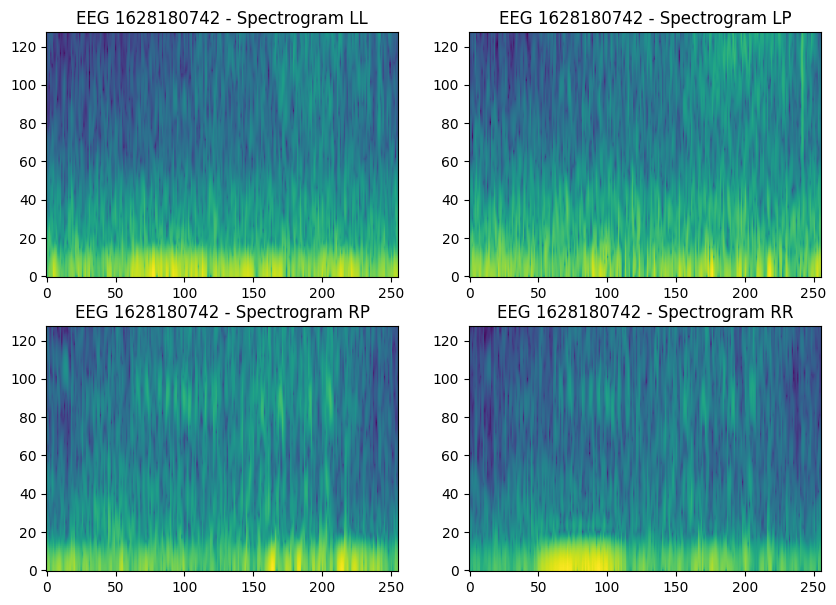

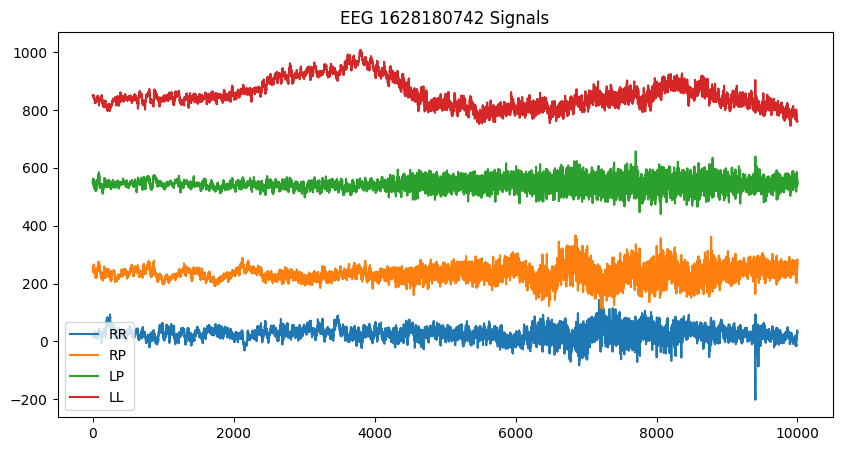


#########################



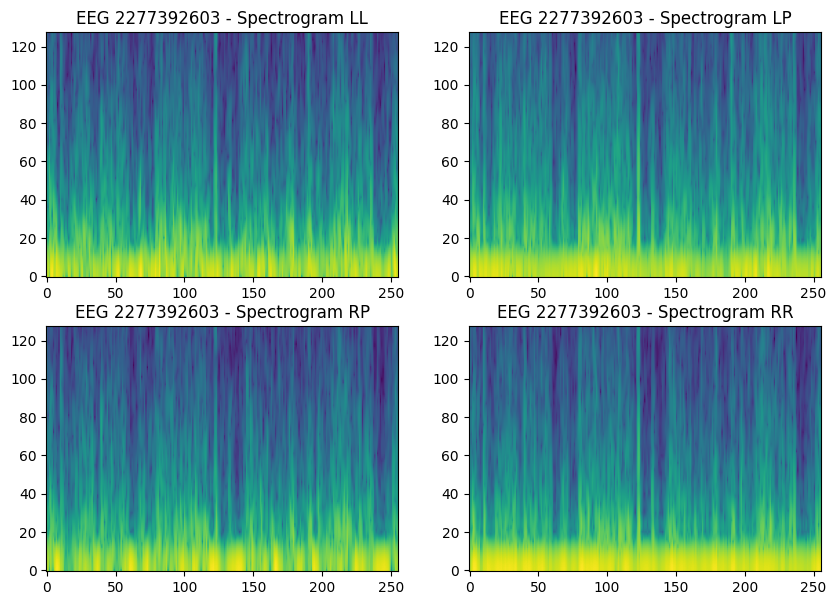

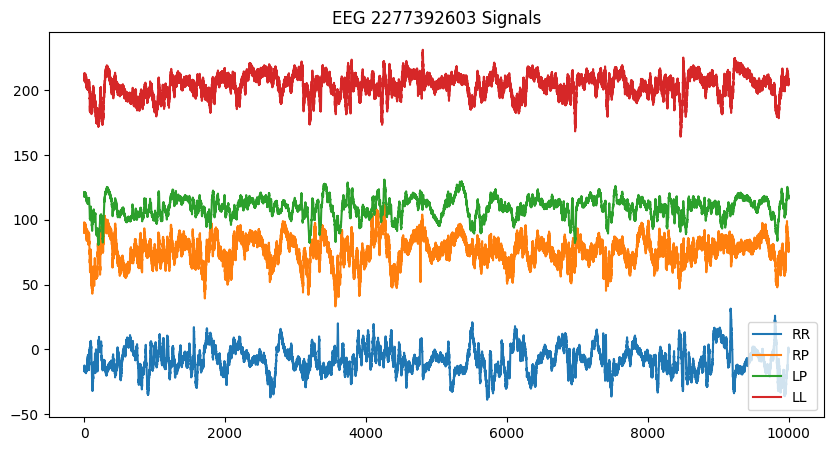


#########################



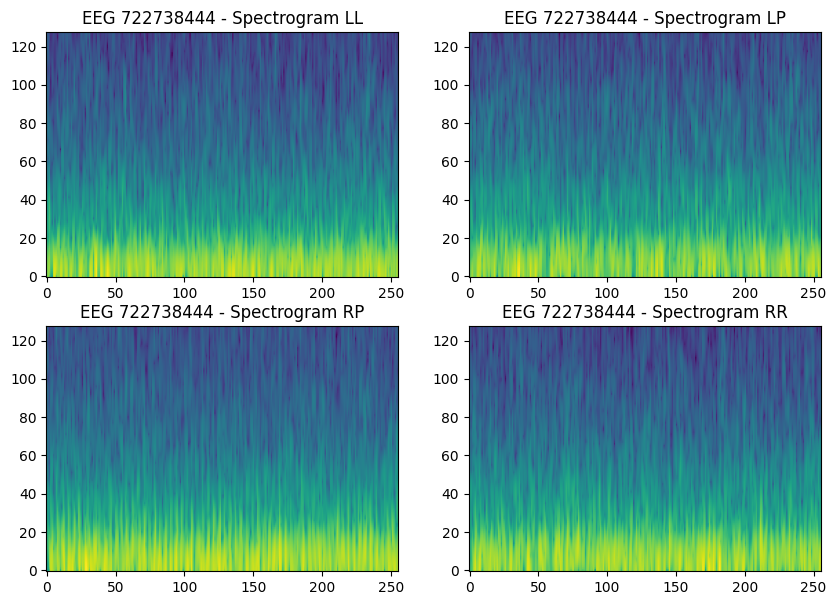

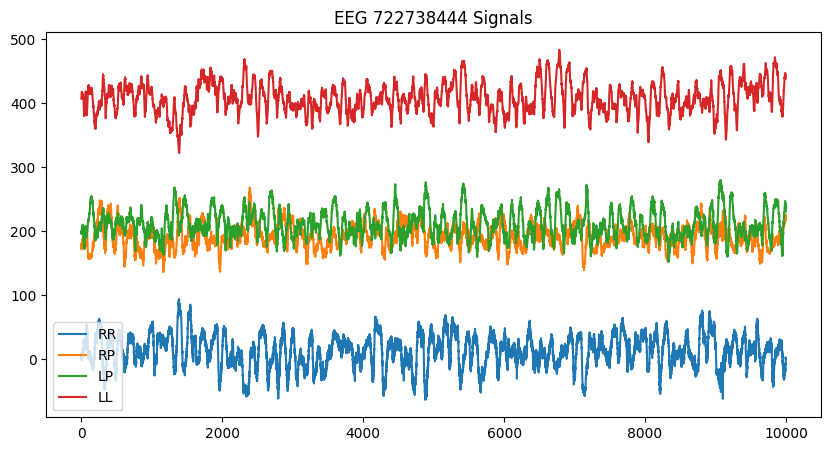


#########################



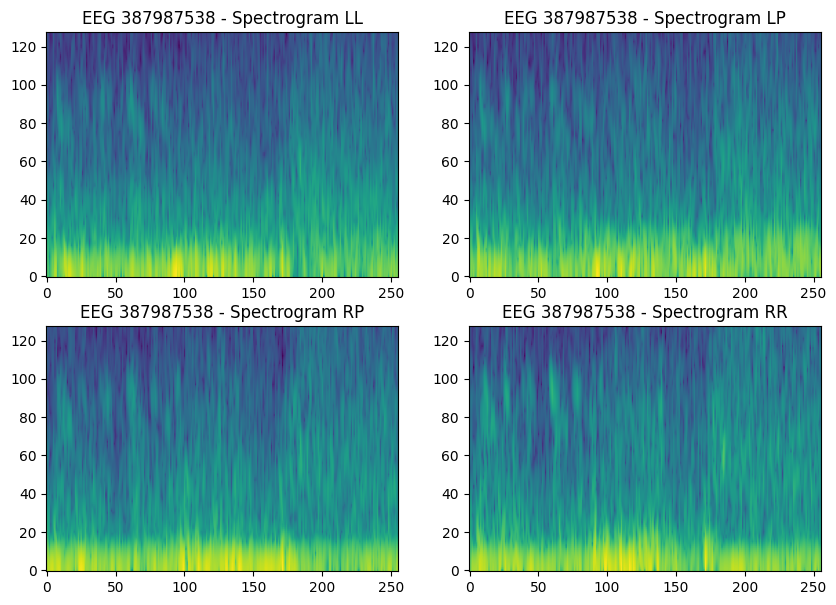

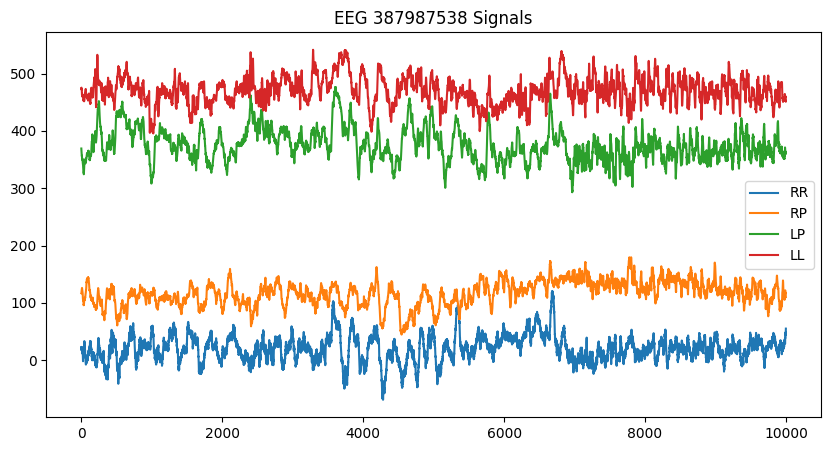


#########################

Creating and writing 17089 spectrograms to disk... 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 12500 , 12600 , 12700 , 12800 , 12900

In [6]:
%%time
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
all_eegs = {}

for i,eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i,', ',end='')
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH}{eeg_id}.parquet', i<DISPLAY)
    
    # SAVE TO DISK
    if i==DISPLAY:
        print(f'Creating and writing {len(EEG_IDS)} spectrograms to disk... ',end='')
    np.save(f'{directory_path}{eeg_id}',img)
    all_eegs[eeg_id] = img
   
# SAVE EEG SPECTROGRAM DICTIONARY
np.save('eeg_specs',all_eegs)

# Kaggle Dataset
The new EEG spectrograms from version 4 of this notebook have been uploaded to a Kaggle dataset [here][4]. We can attach this Kaggle dataset to our future notebooks to boost our CV scores and LB scores! Thank you everyone for upvoting my new EEG spectrogram Kaggle dataset!

Examples of how to use EEG spectrograms to boost CV score and LB score will be (or already are) published in recent versions of my EfficientNet starter notebook [here][2] and CatBoost starter notebook [here][3]

Enjoy! Happy Kaggling!

[2]: https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57
[3]: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-67
[4]: https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms